# IMPORTS

In [4]:
import warnings
warnings.simplefilter("ignore")

In [208]:
import re
import sqlite3
import pickle
import s3fs
import os

import numpy                 as np
import pandas                as pd
import seaborn               as sns
import umap.umap_            as umap

import matplotlib.pyplot       as plt

from pandas_profiling        import ProfileReport
from sklearn.cluster         import DBSCAN, KMeans
from sklearn.metrics         import silhouette_score, silhouette_samples      
from sklearn.ensemble        import RandomForestRegressor
from sklearn.preprocessing   import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition   import PCA
from sklearn.manifold        import TSNE      
from sklearn.mixture         import GaussianMixture
from sklearn.neighbors       import NearestNeighbors

from scipy.cluster.hierarchy import linkage, fcluster
from sqlalchemy              import create_engine
from IPython.display         import display,HTML

## HELPER FUNCTIONS

In [94]:
display(HTML("<style>.container { width:75% !important; }</style>"))

## LOADING DATA

In [6]:
# loading data
df = pd.read_csv('../data/Ecommerce.csv', encoding='cp437' )

# drop empty column
df = df.drop( columns=['Unnamed: 8'], axis=1 )

# DESCRIÇÃO DOS DADOS

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


## RENOMEAR AS COLUNAS

In [8]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [9]:
colunas_renomeadas = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']
df.columns = colunas_renomeadas

## DIMENSÃO DO DATASET

In [10]:
print(f'O dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas')

O dataset possui 541909 linhas e 8 colunas


## RESUMO DOS DADOS

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice_no    541909 non-null  object 
 1   stock_code    541909 non-null  object 
 2   description   540455 non-null  object 
 3   quantity      541909 non-null  int64  
 4   invoice_date  541909 non-null  object 
 5   unit_price    541909 non-null  float64
 6   customer_id   406829 non-null  float64
 7   country       541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


## VERIFICAR DADOS NA

In [12]:
# soma dos dados faltantes
df.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [13]:
# porcentagem dos dados faltantes
porcentagem_faltantes = (df.isnull().sum().sort_values(ascending=False) / len(df)) * 100

# inserir o sinal de % nos resultados
porcentagem_faltantes_com_percentual = porcentagem_faltantes.map('{:.2f}%'.format)

# exibir os resultados
porcentagem_faltantes_com_percentual

customer_id     24.93%
description      0.27%
invoice_no       0.00%
stock_code       0.00%
quantity         0.00%
invoice_date     0.00%
unit_price       0.00%
country          0.00%
dtype: object

## ANÁLISE DADOS NA

In [14]:
# criando dataframes para comparação de customer_id
df_faltantes = df.loc[df['customer_id'].isna(), :]
df_nao_faltantes = df.loc[~df['customer_id'].isna(), :]

In [15]:
print(f'Quantidade de customer_id faltantes: {df_faltantes.shape[0]}')
print(f'Quantidade de customer_id não faltantes: {df_nao_faltantes.shape[0]}')

Quantidade de customer_id faltantes: 135080
Quantidade de customer_id não faltantes: 406829


In [16]:
# criando lista com o invoice_no dos dados faltantes
invoice_no_faltantes = df_faltantes['invoice_no'].drop_duplicates().tolist()

# verificando se há invoice_no correspondentes aos dados sem customer_id
df_nao_faltantes['invoice_no'].isin(invoice_no_faltantes).value_counts()

invoice_no
False    406829
Name: count, dtype: int64

In [17]:
df = df.dropna()
df.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

## MODIFICAR O TIPO DOS DADOS

In [18]:
# invoice_date de object para datetime
df['invoice_date'] = pd.to_datetime(df['invoice_date'], format='%d-%b-%y')

# customer_id de float64 para int64
df['customer_id'] = df['customer_id'].astype(int)

In [19]:
df.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## ANÁLISE DAS FEATURES

In [20]:
num_attributes = df.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### FEATURES NUMÉRICAS

In [21]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
quantity,406829.0,12.061303,-80995.0,2.0,5.0,12.0,80995.0,248.69337
invoice_date,406829,2017-07-08 03:16:19.124890624,2016-11-29 00:00:00,2017-04-04 00:00:00,2017-07-29 00:00:00,2017-10-18 00:00:00,2017-12-07 00:00:00,NaN
unit_price,406829.0,3.460471,0.0,1.25,1.95,3.75,38970.0,69.315162
customer_id,406829.0,15287.69057,12346.0,13953.0,15152.0,16791.0,18287.0,1713.600303


### FEATURE CATEGÓRICAS

#### INVOICE_NO

In [22]:
# identificando invoice_no que possui letra em suas variáveis 
df_invoice_com_letra = df.loc[df['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]

In [23]:
# verificando quantos destes dados possuem quantidade negativa
df_invoice_qtde_negativa = df_invoice_com_letra[ df_invoice_com_letra['quantity'] < 0 ]

In [24]:
print(f'Total de dados que possuem letras: {df_invoice_com_letra.shape[0]}')
print(f'Total de dados que possuem quantidade negativa: {df_invoice_qtde_negativa.shape[0]}')

Total de dados que possuem letras: 8905
Total de dados que possuem quantidade negativa: 8905


#### STOCK_CODE

In [25]:
# verificando quais dados possuem apenas letras e se conseguimos atribuir a vendas
df_stock_code_letters = df.loc[df['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()
df_stock_code_letters

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

In [26]:
df_aux = df[df['stock_code'].isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'])]
df_aux

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
45,536370,POST,POSTAGE,3,2016-11-29,18.00,12583,France
141,C536379,D,Discount,-1,2016-11-29,27.50,14527,United Kingdom
386,536403,POST,POSTAGE,1,2016-11-29,15.00,12791,Netherlands
1123,536527,POST,POSTAGE,1,2016-11-29,18.00,12662,Germany
2239,536569,M,Manual,1,2016-11-29,1.25,16274,United Kingdom
...,...,...,...,...,...,...,...,...
541216,581494,POST,POSTAGE,2,2017-12-07,18.00,12518,Germany
541541,C581499,M,Manual,-1,2017-12-07,224.69,15498,United Kingdom
541730,581570,POST,POSTAGE,1,2017-12-07,18.00,12662,Germany
541767,581574,POST,POSTAGE,2,2017-12-07,18.00,12526,Germany


#### DESCRIPTION

In [27]:
# remover a variável description
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


#### COUNTRY

In [28]:
# verificando os país únicos
df['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [29]:
# distribuição dos dados por país
df['country'].value_counts(normalize=True)

country
United Kingdom          0.889509
Germany                 0.023339
France                  0.020871
EIRE                    0.018398
Spain                   0.006226
Netherlands             0.005828
Belgium                 0.005086
Switzerland             0.004614
Portugal                0.003638
Australia               0.003095
Norway                  0.002669
Italy                   0.001974
Channel Islands         0.001863
Finland                 0.001708
Cyprus                  0.001529
Sweden                  0.001136
Austria                 0.000986
Denmark                 0.000956
Japan                   0.000880
Poland                  0.000838
USA                     0.000715
Israel                  0.000615
Unspecified             0.000600
Singapore               0.000563
Iceland                 0.000447
Canada                  0.000371
Greece                  0.000359
Malta                   0.000312
United Arab Emirates    0.000167
European Community      0.000150
RS

In [30]:
# clientes únicos por país
df[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False)

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


# FILTRO DE VARIÁVEIS

In [59]:
df1 = df.copy()

In [60]:
# feature numérica unit_price com valores acima de 0.04
df1 = df1.loc[df1['unit_price'] >= 0.04, :]

# feature categórica stock_code remover valores
df1 = df1[~df1['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 
                                   'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# feature categórica description remover completamente
df1 = df1.drop(columns='description', axis=1)

# feature categórica country remover não especificados e não países
df1 = df1[~df1['country'].isin(['European Community', 'Unspecified'])]

# usuário com resultados muito divergentes
df1 = df1[~df1['customer_id'].isin([16446])]

# feature numérica quantity dividida em 2 novos dataframes
df1_devolucoes = df1.loc[df1['quantity'] < 0, :]
df1_vendas = df1.loc[df1['quantity'] > 0, :]

# FEATURE ENGINEERING

In [61]:
df2 = df1.copy()

In [62]:
# tabela referência
df_ref = df2.drop(['invoice_no', 'stock_code', 'quantity',  
                   'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

## GROSS_REVENUE

In [63]:
# gross_revenue -> quantity * unit_price = gross_revenue (faturamento, receita_bruta)
df1_vendas.loc[:, 'gross_revenue'] = df1_vendas.loc[:, 'quantity'] * df1_vendas.loc[:, 'unit_price']

# valor monetário
df_vm = df1_vendas.loc[:, ['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_vm, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
dtype: int64

## RECÊNCIA

In [64]:
# recência - diferença entre a data máxima do dataset e a data da última compra do cliente
df_recencia = df1_vendas[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recencia['recency_days'] = (df2['invoice_date'].max() - df_recencia['invoice_date']).dt.days
df_recencia = df_recencia[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recencia, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

## QUANTIDADE DE COMPRAS

In [65]:
# quantidade de compra - quantidade de vezes que o cliente realizou uma compra num período de tempo determinado
df_qtde = df1_vendas.loc[:, ['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'total_orders'})
df_ref = pd.merge(df_ref, df_qtde, on='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
total_orders     27
dtype: int64

## NÚMERO DE PRODUTOS ÚNICOS POR COMPRA

In [66]:
# quantidade de produtos únicos 
df_prod_uniq = (df1_vendas.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                                .reset_index()
                                                                .rename(columns={'stock_code': 'total_products_ordered'}))

# junção dos dataframes
df_ref = pd.merge(df_ref, df_prod_uniq, on='customer_id', how='left')
df_ref.isna().sum()

customer_id                0
gross_revenue             27
recency_days              27
total_orders              27
total_products_ordered    27
dtype: int64

## QUANTIDADE DE PRODUTOS COMPRADOS

In [67]:
# quantidade de produtos
df_qty_prod = (df1_vendas.loc[:, ['customer_id', 'quantity']].groupby('customer_id').sum()
                                                           .reset_index()
                                                           .rename(columns={'quantity': 'total_quantity'}))
df_ref = pd.merge(df_ref, df_qty_prod, on='customer_id', how='left')
df_ref.isna().sum()

customer_id                0
gross_revenue             27
recency_days              27
total_orders              27
total_products_ordered    27
total_quantity            27
dtype: int64

## FREQUÊNCIA DE COMPRA

In [68]:
df_frequencia_aux = (df1_vendas[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                       .groupby('customer_id')
                                                                       .agg(max_ = ('invoice_date', 'max'),
                                                                            min_ = ('invoice_date', 'min'),
                                                                            days_= ('invoice_date', lambda x: ((x.max() - x.min()).days)+1),
                                                                            buy_ = ('invoice_no', 'count'))).reset_index()

In [69]:
df_frequencia_aux = (df1_vendas[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                                       .groupby('customer_id')
                                                                       .agg(max_ = ('invoice_date', 'max'),
                                                                            min_ = ('invoice_date', 'min'),
                                                                            days_= ('invoice_date', lambda x: ((x.max() - x.min()).days)+1),
                                                                            buy_ = ('invoice_no', 'count'))).reset_index()

# cálculo de frequência
df_frequencia_aux['frequency'] = df_frequencia_aux[['buy_', 'days_']].apply(lambda x: x['buy_']/x['days_'] if x['days_'] != 0 else 0, axis=1)

# junção dos dataframes 
df_ref = pd.merge(df_ref, df_frequencia_aux[['customer_id', 'frequency']], on='customer_id', how='left')

In [70]:
df_ref.isna().sum()

customer_id                0
gross_revenue             27
recency_days              27
total_orders              27
total_products_ordered    27
total_quantity            27
frequency                 27
dtype: int64

## QUANTIDADE MÉDIA DE PRODUTOS POR COMPRA

In [71]:
df_aux = (df1_vendas.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby('customer_id')
                                                                            .agg( n_purchase=('invoice_no', 'nunique'),
                                                                                  n_products=('quantity', 'sum' ))
                                                                            .reset_index())

# cáculo da média
df_aux['avg_basket_size_quantity'] = df_aux['n_products'] / df_aux['n_purchase']

# junção dos dataframes
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size_quantity']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id                  0
gross_revenue               27
recency_days                27
total_orders                27
total_products_ordered      27
total_quantity              27
frequency                   27
avg_basket_size_quantity    27
dtype: int64

## TICKET MÉDIO

In [72]:
# ticket médio
df_avg_ticket = df1_vendas.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id                  0
gross_revenue               27
recency_days                27
total_orders                27
total_products_ordered      27
total_quantity              27
frequency                   27
avg_basket_size_quantity    27
avg_ticket                  27
dtype: int64

## QUANTIDADE MÉDIA DE PRODUTOS ÚNICOS

In [73]:
df_aux = (df1_vendas.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby('customer_id')
                                                                            .agg(n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ))
                                                                            .reset_index())

# cálculo da média
df_aux['avg_basket_size_products'] = df_aux['n_products'] / df_aux['n_purchase']

# junção dos dataframes
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size_products']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id                  0
gross_revenue               27
recency_days                27
total_orders                27
total_products_ordered      27
total_quantity              27
frequency                   27
avg_basket_size_quantity    27
avg_ticket                  27
avg_basket_size_products    27
dtype: int64

## QUANTIDADE MÉDIA DE RECÊNCIA

In [74]:
# quantidade média de dias entre compras
df_aux = df1[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=False)
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_date'] = df_aux['invoice_date'].shift()

In [75]:
df_aux['avg_recency_days'] = df_aux.apply( lambda x: (x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

df_aux = df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id                    0
gross_revenue                 27
recency_days                  27
total_orders                  27
total_products_ordered        27
total_quantity                27
frequency                     27
avg_basket_size_quantity      27
avg_ticket                    27
avg_basket_size_products      27
avg_recency_days            1386
dtype: int64

## QUANTIDADE DE DEVOLUÇÕES

In [76]:
df_devolucoes = df1_devolucoes[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity':'qty_returns'})
df_devolucoes['qty_returns'] = df_devolucoes['qty_returns'] * -1

In [77]:
df_ref = pd.merge(df_ref, df_devolucoes, how='left', on='customer_id')
df_ref.loc[df_ref['qty_returns'].isna(), 'qty_returns'] = 0

df_ref.isna().sum()

customer_id                    0
gross_revenue                 27
recency_days                  27
total_orders                  27
total_products_ordered        27
total_quantity                27
frequency                     27
avg_basket_size_quantity      27
avg_ticket                    27
avg_basket_size_products      27
avg_recency_days            1386
qty_returns                    0
dtype: int64

# EDA

In [79]:
df3 = df_ref.dropna()
df3.isna().sum()

customer_id                 0
gross_revenue               0
recency_days                0
total_orders                0
total_products_ordered      0
total_quantity              0
frequency                   0
avg_basket_size_quantity    0
avg_ticket                  0
avg_basket_size_products    0
avg_recency_days            0
qty_returns                 0
dtype: int64

In [52]:
# data_profiling = ProfileReport(df3)
# data_profiling.to_file('profile_report3.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## ESTUDO DO ESPAÇO DE DADOS

In [110]:
df3.columns

Index(['customer_id', 'gross_revenue', 'recency_days', 'total_orders',
       'total_products_ordered', 'total_quantity', 'frequency',
       'avg_basket_size_quantity', 'avg_ticket', 'avg_basket_size_products',
       'avg_recency_days', 'qty_returns'],
      dtype='object')

In [80]:
# dataset com as features selecionadas
features_selected = ['customer_id', 'gross_revenue', 'recency_days', 'total_orders', 'frequency', 'qty_returns']
df_data_space = df3[features_selected].drop(columns=['customer_id'], axis=1).copy()

In [108]:
mms = MinMaxScaler()

df_data_space['gross_revenue'] = mms.fit_transform(df_data_space[['gross_revenue']])
df_data_space['recency_days']  = mms.fit_transform(df_data_space[['recency_days']])
df_data_space['total_orders']  = mms.fit_transform(df_data_space[['total_orders']])
df_data_space['frequency']     = mms.fit_transform(df_data_space[['frequency']])
df_data_space['qty_returns']   = mms.fit_transform(df_data_space[['qty_returns']])

X = df_data_space.copy()

In [109]:
X.shape

(2968, 5)

### PCA

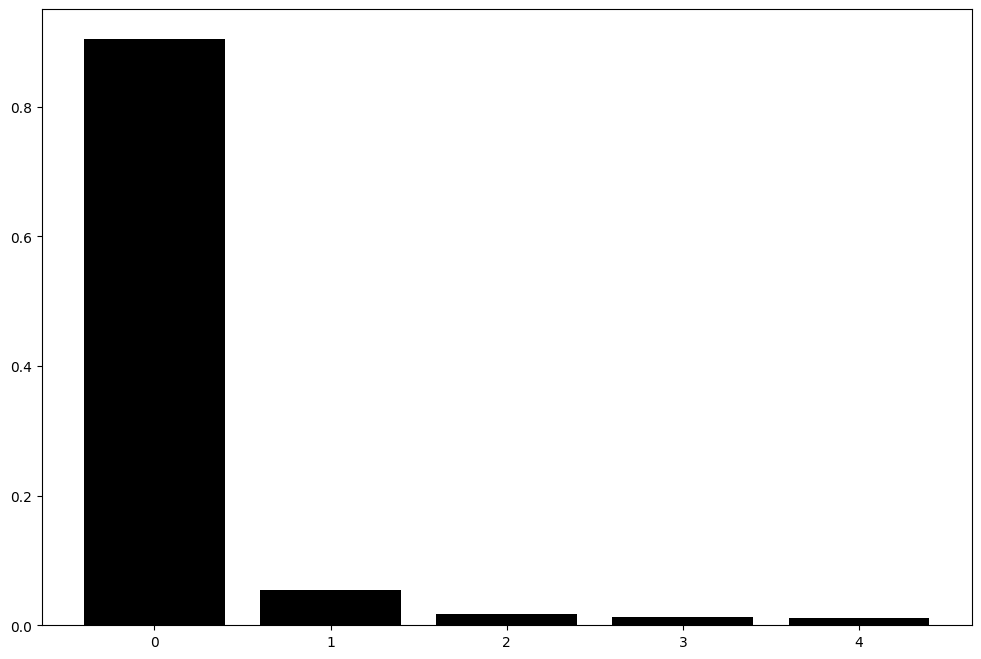

In [99]:
pca = PCA(n_components=X.shape[1])

componentes_pca = pca.fit_transform(X)

# plot com os componentes do PCA
features = range(pca.n_components_)

plt.figure(figsize=(12,8))
plt.bar(features, pca.explained_variance_ratio_, color='black');

# dataframe com componentes do PCA
df_pca = pd.DataFrame(componentes_pca)

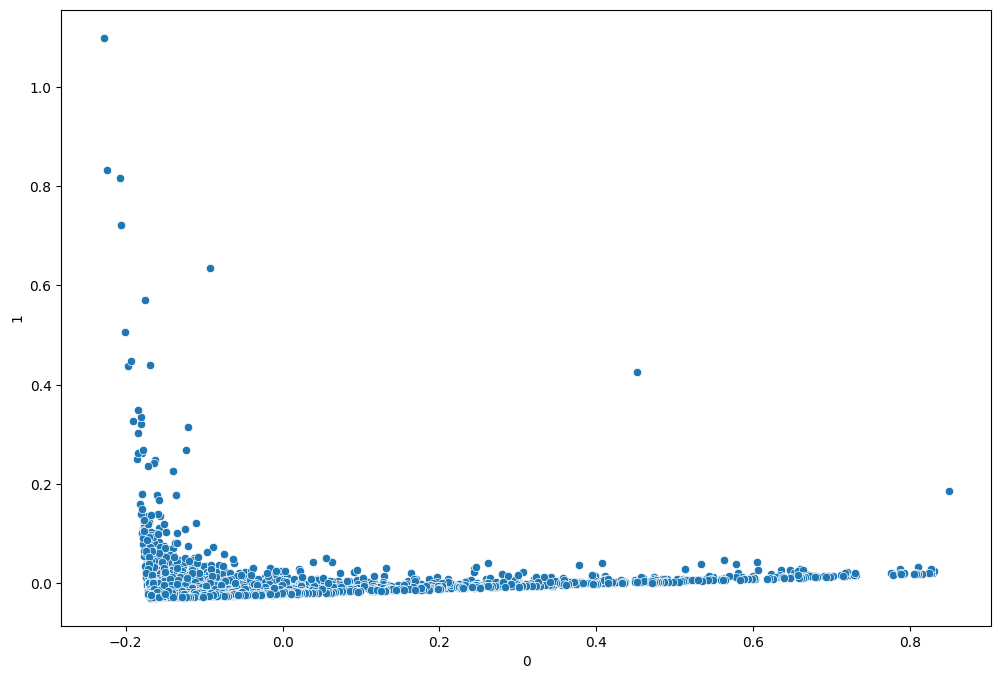

In [100]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=0, y=1, data=df_pca);

### UMAP

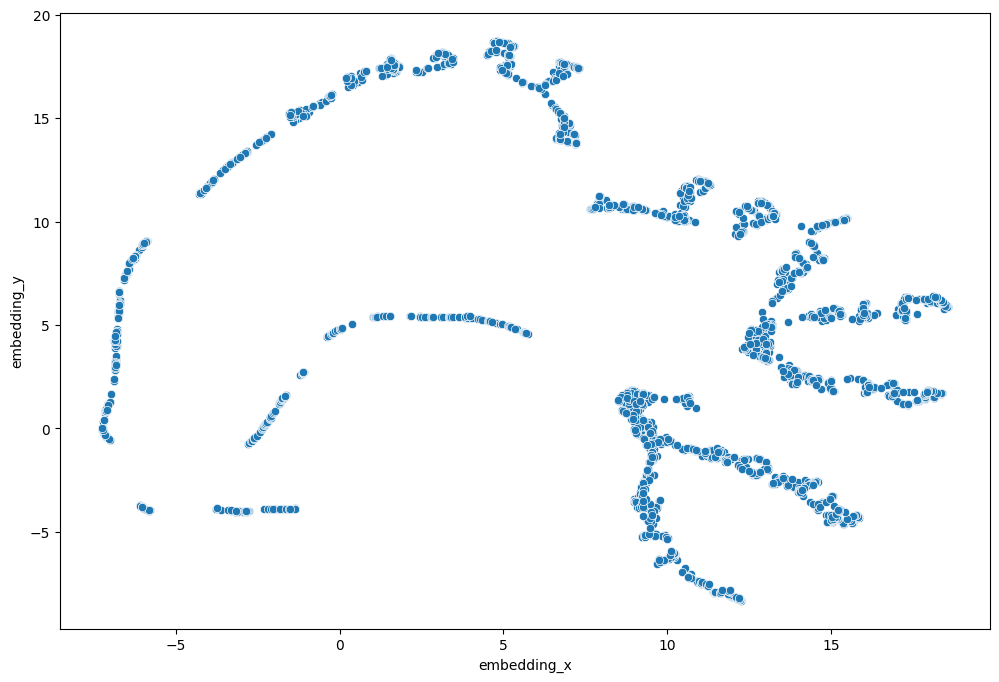

In [101]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# espaço de dados com UMAP
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot do resultado do UMAP
plt.figure(figsize=(12,8))
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_umap);

### t-SNE

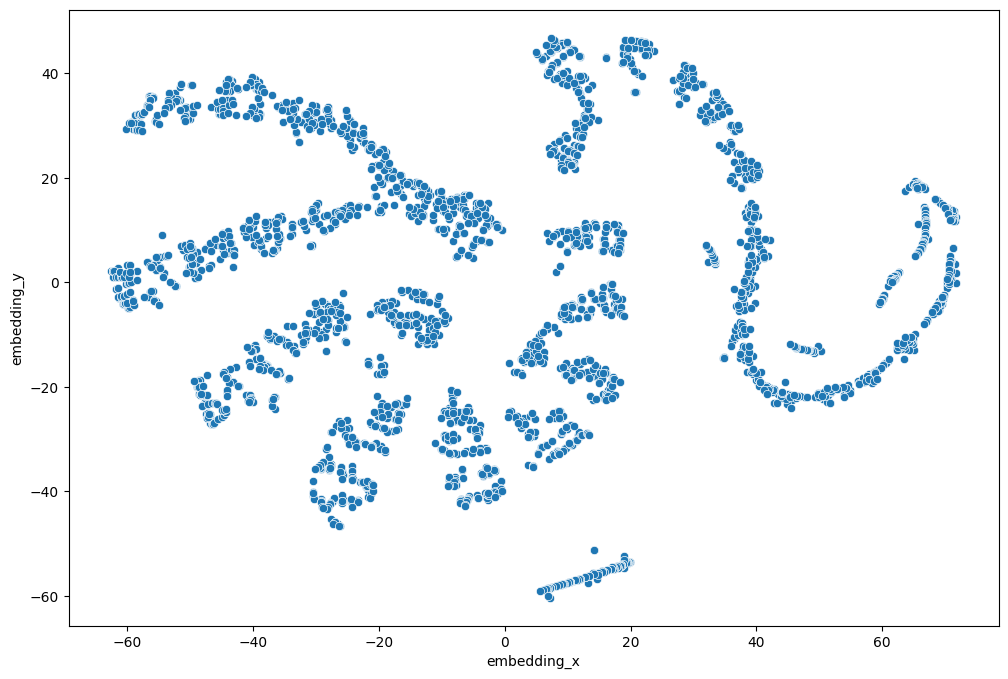

In [104]:
reducer = TSNE(n_components=2, n_jobs=-1, random_state=42)
embedding = reducer.fit_transform(X)

# espaço de dados com TSNE
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot do resultado do TSNE
plt.figure(figsize=(12,8))
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tsne);

### TREE-BASED EMBEDDING

In [106]:
# training dataset
X = df_data_space.drop(columns=['gross_revenue'], axis=1)
y = df_data_space['gross_revenue']

# model definition
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

# Leaf 
df_leaf = pd.DataFrame(rf_model.apply( X ))

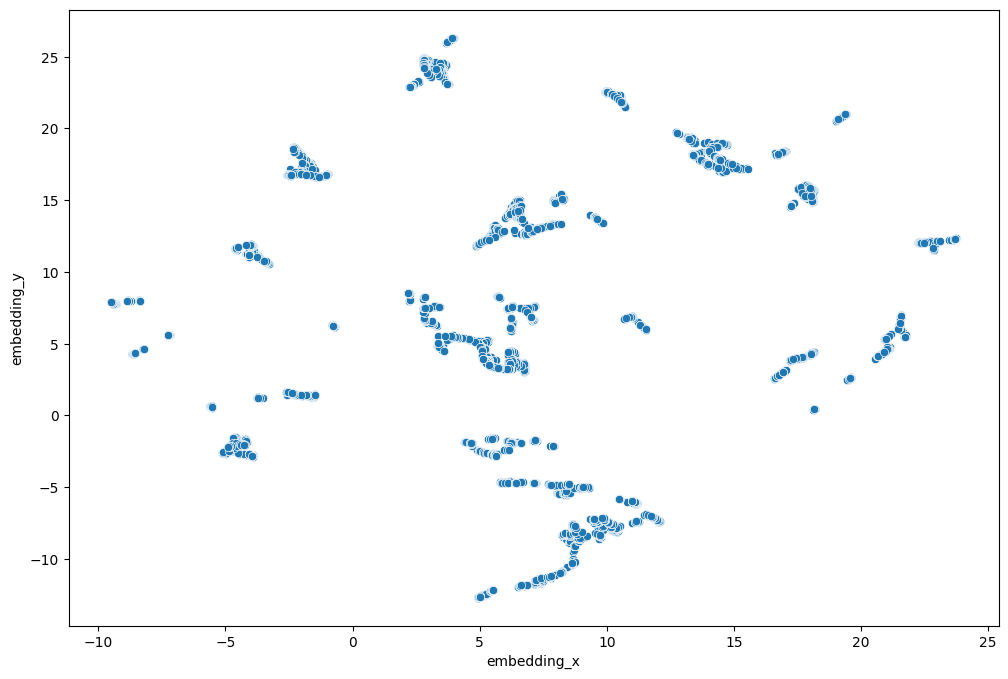

In [125]:
# Reduzer dimensionality
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
plt.figure(figsize=(12,8))
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_tree);

# TESTE DOS DADOS

In [166]:
# Tree-Based Embedding
df5 = df_tree.copy()

# UMAP Embedding
#df5 = df_umap.copy()

# TSNE Embedding
#df5 = df_tsne.copy()

# PARÂMETROS DE CLUSTERS

In [167]:
X = df5.copy()

In [168]:
X.head()

,embedding_x,embedding_y
0,21.192228,5.703211
1,17.933725,15.075303
2,17.715805,3.998596
3,3.515600,23.716904
4,11.484721,6.065127


In [169]:
clusters = np.arange(2, 26)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25])

## KMEANS

In [170]:
kmeans_list = []
for k in clusters:
    # definição do modelo
    kmeans_model = KMeans(n_clusters=k, n_init=100, random_state=42)

    # treino do modelo
    kmeans_model.fit(X)

    # predição do modelo
    labels = kmeans_model.predict(X)

    # score do modelo
    sil = silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

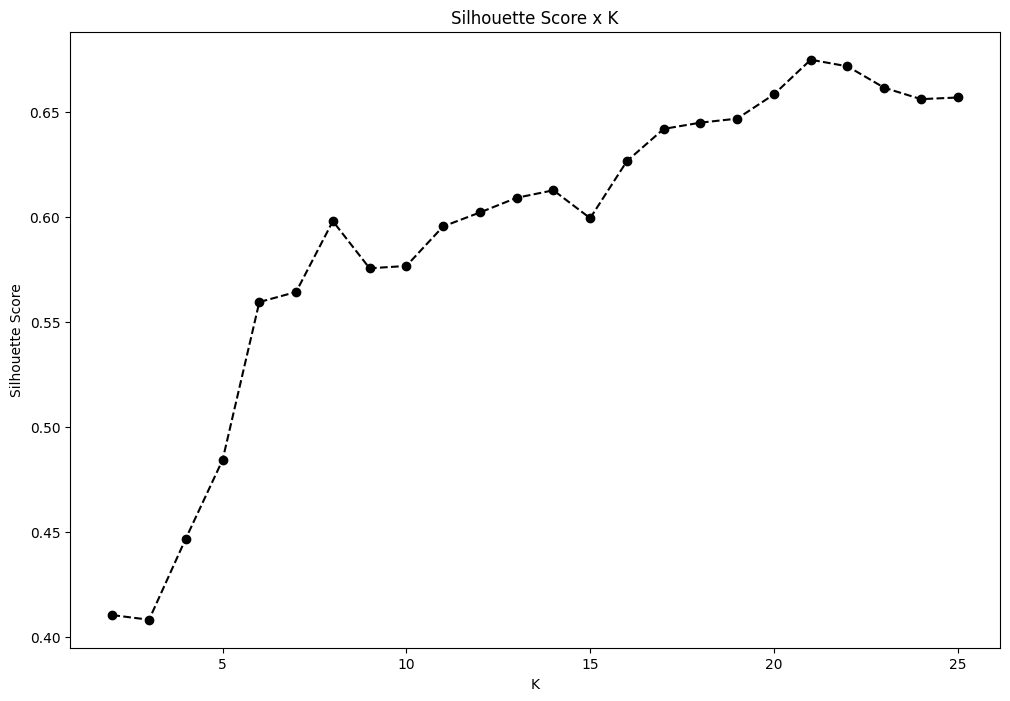

In [171]:
plt.figure(figsize=(12,8))
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='black')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x K');

## GMM (Gaussian Mixture Model)

In [172]:
gmm_list = []
for k in clusters:
    # definição do modelo
    gmm_model = GaussianMixture(n_components=k, n_init=10, random_state=42)

    # treino do modelo
    gmm_model.fit(X)

    # predição do modelo
    labels = gmm_model.predict(X)

    # score do modelo
    sil = silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

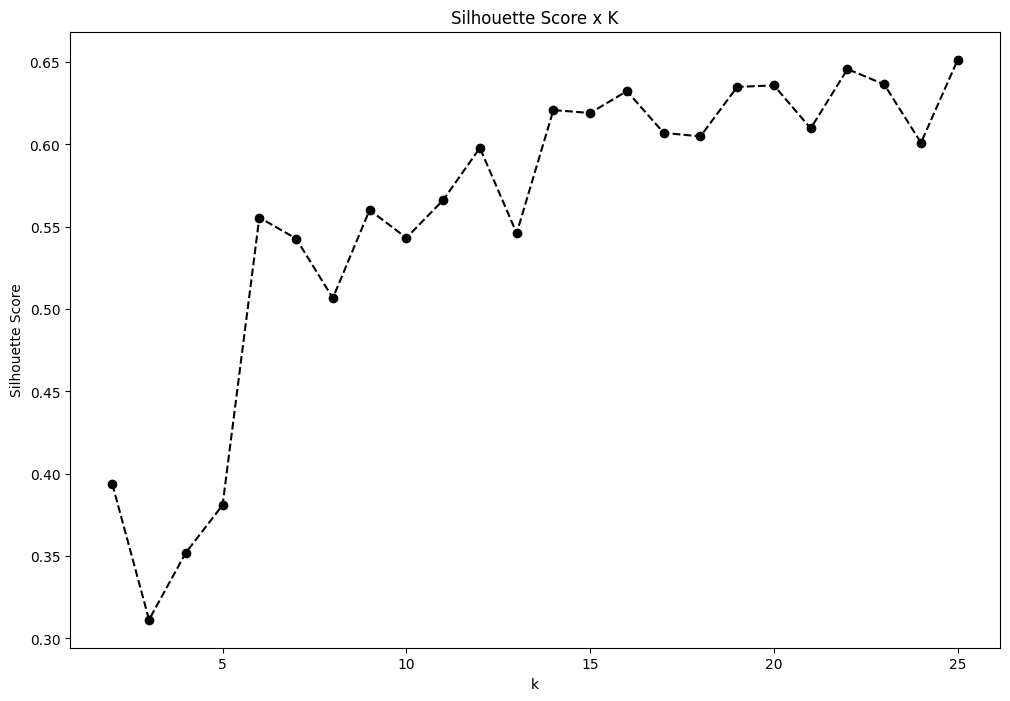

In [173]:
plt.figure(figsize=(12,8))
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='black' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Silhouette Score x K');

## HIERARCHICAL CLUSTERING

In [174]:
# definição do modelo
hc_model = linkage(X, 'ward')

### HIERARCHICAL CLUSTERING SILHOUETTE SCORE

In [175]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = linkage( X, 'ward' )

    # model predict
    labels = fcluster( hc_model, k, criterion='maxclust' )

    # metrics
    sil = silhouette_score( X, labels, metric='euclidean' )
    hc_list.append( sil )

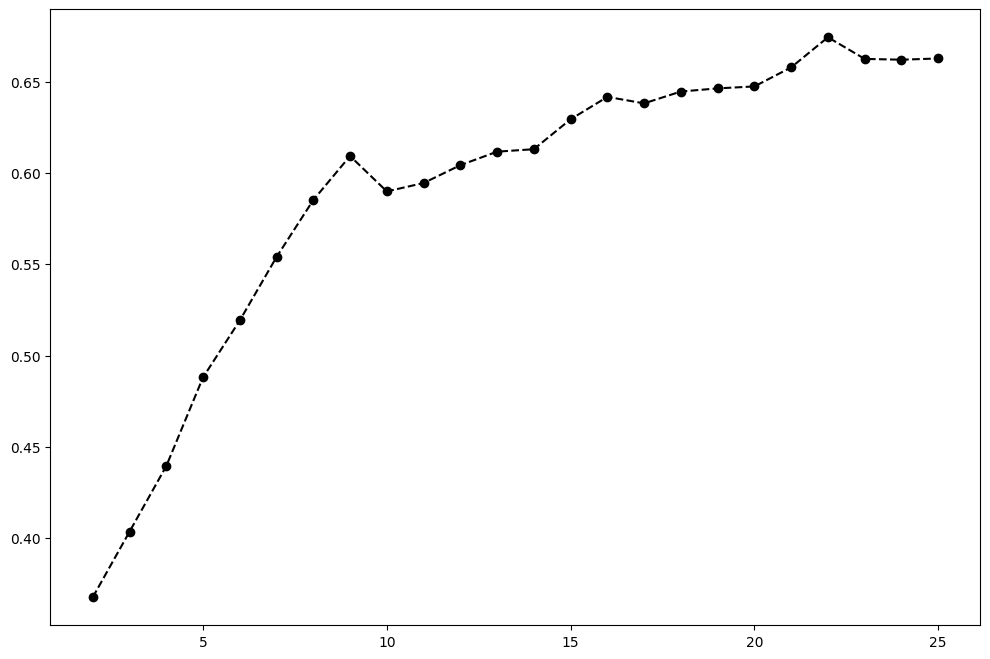

In [176]:
plt.figure(figsize=(12,8))
plt.plot( clusters,  hc_list, linestyle='--', marker='o', color='black' );

In [177]:
## 7.5. Results - Tree Based Embedding

df_results = pd.DataFrame( 
                         {'KMeans': kmeans_list, 
                          'GMM': gmm_list, 
                          'HC': hc_list}
                     ).T

df_results.columns = clusters
df_results.style.highlight_max( color='lightblue', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
KMeans,0.410555,0.408354,0.446964,0.484299,0.559405,0.564196,0.597877,0.575458,0.576577,0.595366,0.602001,0.608973,0.612550,0.599285,0.626425,0.641738,0.644711,0.646617,0.658152,0.674634,0.671493,0.661305,0.655889,0.656671
GMM,0.393752,0.311384,0.352065,0.381000,0.555619,0.542863,0.506731,0.560224,0.543297,0.566201,0.597921,0.546139,0.620896,0.619130,0.632418,0.607064,0.604917,0.634982,0.635884,0.609765,0.645807,0.636477,0.601065,0.651481
HC,0.367617,0.403504,0.439443,0.488025,0.519196,0.553946,0.585147,0.609247,0.589867,0.594455,0.604232,0.611633,0.612980,0.629370,0.641629,0.638084,0.644567,0.646287,0.647354,0.657792,0.674271,0.662431,0.661991,0.662667


In [153]:
## 7.6. Results - UMAP Embedding

df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list}
).T

df_results.columns = clusters
df_results.style.highlight_max( color='lightgreen', axis=1 )

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
KMeans,0.472353,0.508018,0.500478,0.489265,0.478078,0.489947,0.490230,0.500337,0.527082,0.525067,0.525615,0.528611,0.532893,0.547850,0.556257,0.562396,0.563258,0.568992,0.573190,0.569788,0.570806,0.577280,0.575210,0.585222
GMM,0.473998,0.448619,0.417864,0.256508,0.333914,0.423870,0.433203,0.371295,0.475742,0.499593,0.485687,0.506139,0.513598,0.504203,0.477877,0.524380,0.526438,0.502381,0.529825,0.492322,0.448343,0.496092,0.474281,0.499840
HC,0.476228,0.501210,0.504321,0.491024,0.488471,0.500408,0.518543,0.486144,0.515663,0.504904,0.500942,0.509101,0.523456,0.540311,0.548634,0.556415,0.559015,0.569760,0.569146,0.568821,0.571221,0.576009,0.577893,0.582254


In [165]:
## 7.7. Results - TSNE Embedding

df_results = pd.DataFrame( 
    {'KMeans': kmeans_list, 
     'GMM': gmm_list, 
     'HC': hc_list}
).T

df_results.columns = clusters
df_results.style.highlight_max( color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
KMeans,0.413319,0.420964,0.436310,0.427991,0.437461,0.441353,0.445933,0.454718,0.460549,0.466210,0.480327,0.497571,0.497245,0.512650,0.510652,0.529475,0.526080,0.529563,0.527645,0.525767,0.518317,0.511514,0.517356,0.519160
GMM,0.413141,0.420425,0.296875,0.262042,0.290241,0.297742,0.290299,0.340499,0.345181,0.373914,0.396135,0.390413,0.396685,0.390000,0.419017,0.406022,0.414167,0.461522,0.462284,0.471216,0.497366,0.511660,0.471566,0.483054
HC,0.409917,0.386894,0.398697,0.398924,0.396038,0.403487,0.416714,0.420005,0.433317,0.453781,0.464342,0.482568,0.478573,0.475150,0.482938,0.484158,0.485853,0.493626,0.497262,0.503945,0.500483,0.500601,0.507301,0.520360


## DBSCAN

In [254]:
eps=2.00
min_samples=20 

# model definition
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)

# mode training & predict 
labels = dbscan_model.fit_predict(X)

# how many unique labels we have
unique_labels = np.unique(labels)
num_unique_labels = len(unique_labels)

sil = silhouette_score(X, labels, metric='euclidean')
print(f'Silhouette Score: {sil}')
print(f'Number of Clusters: {num_unique_labels}')

Silhouette Score: 0.6523125171661377
Number of Clusters: 20


In [212]:
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, index = neighbors.kneighbors(X)

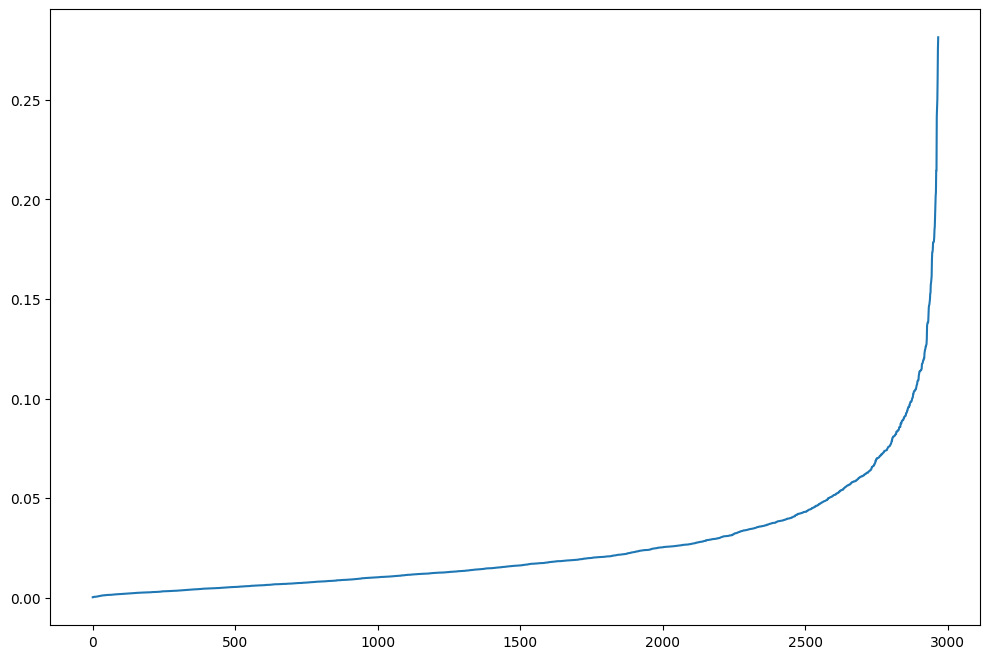

In [213]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(12,8))
plt.plot(distances);

# TREINO DO MODELO

## GMM - MODELO ESCOLHIDO

In [178]:
# model definition
k = 10
gmm_model = GaussianMixture(n_components=k, n_init=100, init_params='k-means++', max_iter=1000, random_state=42)

# model training
gmm_model.fit(X)

# model predict
labels = gmm_model.predict(X)

## SCORE DO MODELO

In [179]:
# SS (Silhouette Score)
print(f'SS Results: {silhouette_score(X, labels, metric="euclidean")}')

SS Results: 0.5694265961647034


# ANÁLISE DOS CLUSTERS

In [183]:
df_cluster = X.copy()
df_cluster['cluster'] = labels

## 9.1. Visualization Inspection

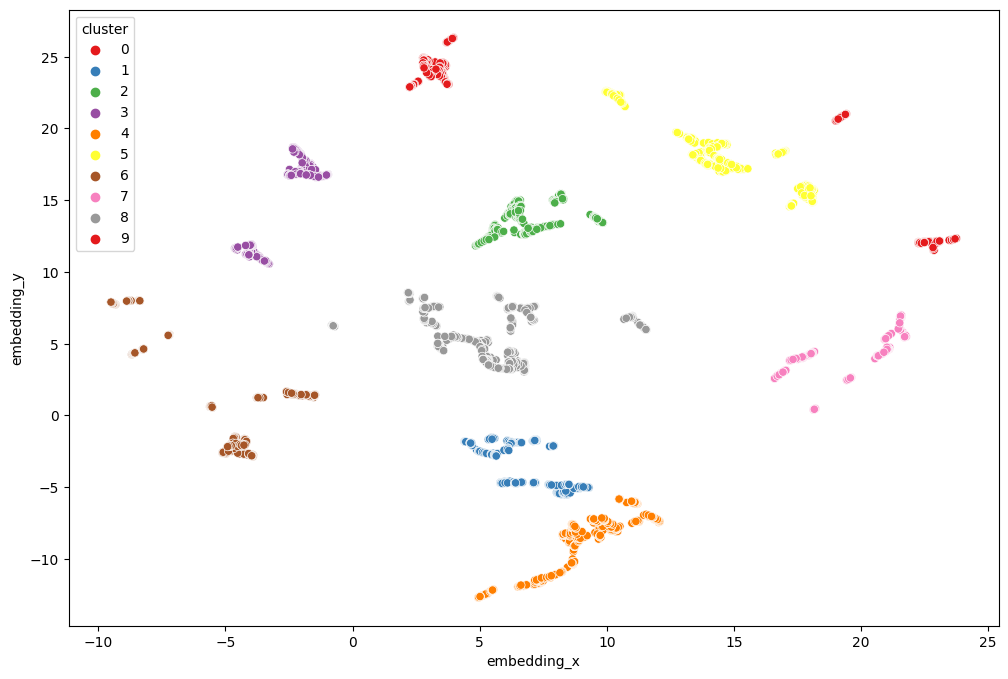

In [191]:
plt.figure(figsize=(12,8))
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df_cluster, palette='Set1');

## 9.4. Cluster Profile

In [196]:
df_cluster = df3.copy()
df_cluster['cluster'] = labels
df_cluster.head()

,customer_id,gross_revenue,recency_days,total_orders,total_products_ordered,total_quantity,frequency,avg_basket_size_quantity,avg_ticket,avg_basket_size_products,avg_recency_days,qty_returns,cluster
0,17850,5391.21,372.0,34.0,297.0,1733.0,17.000000,50.970588,18.152222,0.617647,-35.500000,40.0,7
1,13047,3232.59,56.0,9.0,171.0,1390.0,0.028302,154.444444,18.904035,11.666667,-27.250000,35.0,5
2,12583,6705.38,2.0,15.0,232.0,5028.0,0.040323,335.200000,28.902500,7.600000,-23.187500,50.0,7
3,13748,948.25,95.0,5.0,28.0,439.0,0.017921,87.800000,33.866071,4.800000,-92.666667,0.0,9
4,15100,876.00,333.0,3.0,3.0,80.0,0.073171,26.666667,292.000000,0.333333,-8.600000,22.0,8


In [197]:
# number of customer
df_cluster_profile = df_cluster[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster_profile['perc_customer'] = 100*(df_cluster_profile['customer_id']/df_cluster_profile['customer_id'].sum())

# avg gross revenue
df_avg_gross_revenue = df_cluster[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster_profile = pd.merge(df_cluster_profile, df_avg_gross_revenue, how='inner', on='cluster')

# avg recency days
df_avg_recency_days = df_cluster[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster_profile = pd.merge(df_cluster_profile, df_avg_recency_days, how='inner', on='cluster')

# avg orders
df_avg_orders = df_cluster[['total_orders', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster_profile = pd.merge(df_cluster_profile, df_avg_orders, how='inner', on='cluster')

# avg frequency
df_avg_frequency = df_cluster[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster_profile = pd.merge(df_cluster_profile, df_avg_frequency, how='inner', on='cluster')

# avg quantity of returns
df_avg_qty_returns = df_cluster[['qty_returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster_profile = pd.merge(df_cluster_profile, df_avg_qty_returns, how='inner', on='cluster')

In [198]:
df_cluster_profile.sort_values(by='gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,total_orders,frequency,qty_returns
7,7,251,8.456873,15857.935976,11.884462,24.266932,0.138825,218.402390
0,0,114,3.840970,3887.399035,30.008772,9.877193,0.036473,26.842105
5,5,439,14.791105,2924.007312,30.136674,7.544419,0.033854,57.749431
3,3,240,8.086253,1939.963250,46.033333,5.166667,0.043094,14.612500
9,9,161,5.424528,1640.684472,40.062112,5.000000,0.026585,0.627329
2,2,291,9.804582,1346.534227,52.185567,4.000000,0.039128,0.525773
8,8,505,17.014825,1076.186931,70.235644,2.980198,0.041895,17.708911
6,6,311,10.478437,675.320675,145.273312,1.398714,0.633097,24.041801
1,1,271,9.130728,628.478007,134.752768,2.000000,0.122520,0.442804
4,4,385,12.971698,627.842909,55.545455,2.000000,0.017474,0.044156


Clusters:
- VIP (Highest Rank)
- Platinum
- Gold
- Silver
- Bronze
- Elite
- Preferred
- Standard
- Basic
- Newcomer (Lowest Rank)

# DEPLOY DO MODELO

In [199]:
df_cluster.head()

,customer_id,gross_revenue,recency_days,total_orders,total_products_ordered,total_quantity,frequency,avg_basket_size_quantity,avg_ticket,avg_basket_size_products,avg_recency_days,qty_returns,cluster
0,17850,5391.21,372.0,34.0,297.0,1733.0,17.000000,50.970588,18.152222,0.617647,-35.500000,40.0,7
1,13047,3232.59,56.0,9.0,171.0,1390.0,0.028302,154.444444,18.904035,11.666667,-27.250000,35.0,5
2,12583,6705.38,2.0,15.0,232.0,5028.0,0.040323,335.200000,28.902500,7.600000,-23.187500,50.0,7
3,13748,948.25,95.0,5.0,28.0,439.0,0.017921,87.800000,33.866071,4.800000,-92.666667,0.0,9
4,15100,876.00,333.0,3.0,3.0,80.0,0.073171,26.666667,292.000000,0.333333,-8.600000,22.0,8


In [200]:
df_cluster.dtypes

customer_id                   int64
gross_revenue               float64
recency_days                float64
total_orders                float64
total_products_ordered      float64
total_quantity              float64
frequency                   float64
avg_basket_size_quantity    float64
avg_ticket                  float64
avg_basket_size_products    float64
avg_recency_days            float64
qty_returns                 float64
cluster                       int64
dtype: object